In [2]:
import sys
from box import Box
import numpy as np
import torch.nn.functional as F
from collections import OrderedDict
from tqdm import tqdm
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter
from pprint import pprint
from itertools import product
import shap

sys.path.append('../')
from util.xai_utils import *
import utils

## Utility

In [76]:
def convert_to_tensor(nested_array):
    if isinstance(nested_array, list):
        return torch.stack([convert_to_tensor(x) for x in nested_array])
    else:
        return torch.tensor(np.array(nested_array), dtype=torch.float32)

In [77]:
def get_appr_params(base_path, T=2):
    dict_appr_params  = {} 
    alpha, beta = None, None
    results_files = [elem for elem in glob(f'{base_path}/results/*') if (('outputs_targets_features_' in elem) \
                        and elem.split('/')[-1].split('-')[0].split('_')[-1]=='1')]
    if len(results_files)==0:
        results_files = [elem for elem in glob(f'{base_path}/results/*') if 'per_class_metrics' in elem]
    for out_path in results_files:    
        timestamp = out_path.split('.')[-2].split('-')[-1].split('_')[0]
        args_file = f'{base_path}/args-{timestamp}.txt'
        stdout_file = f'{base_path}/stdout-{timestamp}.txt'
        with open(stdout_file) as f:
            lines = f.readlines()
        with open(args_file) as f:
            args = Box(json.loads(f.read()))
        t = float(args.get('T', default = 2))
        if t==T:
            class_order = ''
            for l in lines:
                if 'BiC training for Task 1' in l:
                    alpha=float(l.split('alpha=')[-1].split(',')[0])
                    beta=float(l.split('beta=')[-1])
                if '[[' in l and ']]' in l:
                    class_order=[int(elem) for elem in l.split(']]')[0].replace('[','').replace(']','').replace('','').split(',')]
                    class_order=[class_order[:args.nc_first_task], class_order[args.nc_first_task:]]
            dict_appr_params[args.seed]={'alpha':alpha, 'beta':beta,
                'timestamp':timestamp, 'class_order':class_order}
    return dict_appr_params

In [78]:
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self, npkts=10, nfeat=4, nc_base=10, nc_incr=7):
        super(Net, self).__init__()
        self.alpha = 1
        self.beta = 0
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(4,2), stride=(1,1), padding=0)
        self.relu1 = nn.ReLU()
        self.max1 = nn.MaxPool2d((3,2), (1,1), 0)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(4,2), stride=(1, 1), padding=0)        
        self.max2 = nn.MaxPool2d((3,1), stride=(1,1), padding=0)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(npkts*nfeat*64,200)        
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(200, nc_base)
        self.fc3 = nn.Linear(200, nc_incr)
        self.softmax = nn.Softmax(dim=1)

        self.paddings0 = [(1, 2), (1, 1), (1, 2), (1, 1)]
        self.paddings1 = [(0, 1), (0, 1), (0, 1), (0, 1)]
        self.pool_kernel0 = (3, 2)
        self.pool_kernel1 = (3, 1) if nfeat < 6 else self.pool_kernel0
        self.pool_stride = (1, 1)

    def extract_features(self, x):
        x = F.pad(x, (0, 1) + (1, 2))
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.pad(x, (0, 1) + (1, 1))
        x = self.max1(x)
        x = self.bn1(x)
        x = F.pad(x, (0,1) + (1,2))
        x = self.conv2(x)
        x = self.relu2(x)
        x = F.pad(x, (0,0) + (1,1))
        x = self.max2(x)
        x = self.bn2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        return x
    
    def forward(self, x):
        x = self.relu3(self.extract_features(x))
        x1 = self.fc2(x)
        x2 = self.fc3(x)
        x2= self.alpha * x2 + self.beta
        x = torch.cat((x1, x2), dim=1)
        return x
        

In [79]:
model = Net()
 
model_path = f'{appr_path}/models/task1-{ts}.ckpt'
base_model = torch.load(model_path)
 
base_model['model.fc2.weight'] = base_model['heads.0.weight']
del base_model['heads.0.weight']
 
base_model['model.fc2.bias'] = base_model['heads.0.bias']
del base_model['heads.0.bias']
 
base_model['model.fc3.weight'] = base_model['heads.1.weight']
del base_model['heads.1.weight']
 
base_model['model.fc3.bias'] = base_model['heads.1.bias']
del base_model['heads.1.bias']
 
base_model2 = OrderedDict()
 
for k in base_model.keys():
    base_model2['.'.join(k.split('.')[1:])] = base_model[k]
 
model.load_state_dict(base_model2)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 2), stride=(1, 1))
  (relu1): ReLU()
  (max1): MaxPool2d(kernel_size=(3, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 2), stride=(1, 1))
  (max2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2560, out_features=200, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=200, out_features=10, bias=True)
  (fc3): Linear(in_features=200, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)

## Data

In [80]:
appr_path = '../results/src_iot-nidd_dst_ton-iot_bic-mem/'

dict_bic = get_appr_params(appr_path)

print(dict_bic)

seed = 1
ts = dict_bic[seed]['timestamp']

args_path = f'{appr_path}/args-{ts}.txt'
with open(args_path) as f:
    args = Box(json.loads(f.read()))

assert args.seed == seed

utils.seed_everything(seed=args.seed)
trn_loader, val_loader, tst_loader, taskcla = get_loaders(
        args.datasets, args.num_tasks, args.nc_first_task, args.nc_incr_tasks, args.batch_size,
        validation=0.1, num_workers=0, num_pkts=args.num_pkts, fields=args.fields, seed=args.seed
    )

{1: {'alpha': 1.08663, 'beta': 0.09829, 'timestamp': '1728922456366034', 'class_order': [[], [6, 5, 1, 0, 2, 4, 9, 7, 8, 3, 11, 9, 13, 2, 16, 15, 3, 6, 7, 14, 10, 12]]}}
Index(['SCALED_PL', 'SCALED_IAT', 'SCALED_DIR', 'SCALED_WIN', 'ENC_LABEL',
       'IS_TRAIN'],
      dtype='object')
Class order:  [6, 5, 1, 0, 2, 4, 9, 7, 8, 3]


Index(['SCALED_PL', 'SCALED_IAT', 'SCALED_DIR', 'SCALED_WIN', 'ENC_LABEL',
       'IS_TRAIN'],
      dtype='object')
Class order:  [3, 0, 8, 6, 11, 10, 1, 4, 7, 9, 2, 5]
[ 2  3  6  7  9 10 11 12 13 14 15 16]
[(0, 12)]
[[6, 5, 1, 0, 2, 4, 9, 7, 8, 3], [11, 9, 13, 2, 16, 15, 3, 6, 7, 14, 10, 12]] [(1, 7)]


In [81]:
def get_classes(fn):
    with open(fn) as fin:
        classes = fin.readlines()
    return [c.strip() for c in classes if c.strip()]

In [82]:
print(args.datasets)

data_paths = {
    'iot_nidd': '../../data/uniform_label/iot-nidd_dwn10p_prep1.parquet',
    'edge_iiot': '../../data/uniform_label/edge-iiot_dwn10p_prep1.parquet',
    'ton_iot': '../../data/uniform_label/ton-iot_dwn10p_prep1.parquet',
}

classes_paths = {
    'iot_nidd': '../../data/uniform_label/classes_iot-nidd.txt',
    'edge_iiot': '../../data/uniform_label/classes_edge-iiot.txt',
    'ton_iot': '../../data/uniform_label/classes_ton-iot.txt',
}

dfs = [pd.read_parquet(data_paths[d]) for d in args.datasets]

for d, df in zip(args.datasets, dfs):
    str_classes = get_classes(classes_paths[d])
    df['LABEL'] = df['ENC_LABEL'].apply(lambda x: str_classes[x])


['iot_nidd', 'ton_iot']


In [83]:
trn_instances_source = torch.concat([x for x, y in trn_loader[0]], axis=0)
trn_instances_target = torch.concat([x for x, y in trn_loader[1]], axis=0)

tst_instances_source = torch.concat([x for x, y in tst_loader[0]], axis=0)
tst_instances_target = torch.concat([x for x, y in tst_loader[1]], axis=0)

trn_labels_source = torch.concat([y for x, y in trn_loader[0]], axis=0)
trn_labels_target = torch.concat([y for x, y in trn_loader[1]], axis=0)

tst_labels_source = torch.concat([y for x, y in tst_loader[0]], axis=0)
tst_labels_target = torch.concat([y for x, y in tst_loader[1]], axis=0)

val_labels_source = torch.concat([y for x, y in val_loader[0]], axis=0)
val_labels_target = torch.concat([y for x, y in val_loader[1]], axis=0)

In [84]:
vc_src = dfs[0]['LABEL'].value_counts().to_dict()
vc_tgt = dfs[1]['LABEL'].value_counts().to_dict()

In [85]:
avc_src = Counter(np.concatenate((trn_labels_source, tst_labels_source, val_labels_source)))
avc_tgt = Counter(np.concatenate((trn_labels_target, tst_labels_target, val_labels_target)))

In [86]:
def get_enc_to_str(enc_dict, str_dict):
    n_enc_dict = []
    n_str_dict = []

    enc_dict_val_sort = list(sorted(enc_dict.values()))
    str_dict_val_sort = list(sorted(str_dict.values()))

    for v in enc_dict_val_sort:
        k = [k for k, v0 in enc_dict.items() if v == v0][0]
        n_enc_dict.append((k, v))
    
    for v in str_dict_val_sort:
        k = [k for k, v0 in str_dict.items() if v == v0][0]
        n_str_dict.append((k, v))

    enc_to_str_dict = {}

    for v0, v1 in product(n_enc_dict, n_str_dict):
        if v0[1] == v1[1]:
            enc_to_str_dict[v0[0]] = v1[0]

    mis_n_enc_dict = [v for v in n_enc_dict if v[0] not in enc_to_str_dict.keys()]
    mis_n_str_dict = [v for v in n_str_dict if v[0] not in enc_to_str_dict.values()]

    assert len(mis_n_enc_dict) == len(mis_n_str_dict)

    if len(mis_n_enc_dict) == 1:
        enc_to_str_dict[mis_n_enc_dict[0][0]] = mis_n_str_dict[0][0]
    else:
        mis_n_enc_dict = sorted(mis_n_enc_dict, key=lambda x: x[1])
        mis_n_str_dict = sorted(mis_n_str_dict, key=lambda x: x[1])
        for enc, _str in zip(mis_n_enc_dict, mis_n_str_dict):
            enc_to_str_dict[enc[0]] = _str[0]
    
    return enc_to_str_dict

enc_to_str_src_dict = get_enc_to_str(avc_src, vc_src)
enc_to_str_dict = get_enc_to_str(avc_tgt, vc_tgt)

In [87]:
data = pd.read_parquet(f'{appr_path}/results/logits_features_targets_test_{args.seed}_1-{ts}.parquet')
res = pd.read_parquet(f'{appr_path}/results/outputs_targets_features_{args.seed}_1-{ts}.parquet')

assert (data['Targets'][0] == res['Targets'][0][0]).all()
assert (data['Targets'][1] == res['Targets'][0][1]).all()

inputs_src = data['Inputs'][0].copy()
inputs_tgt = data['Inputs'][1].copy()

true_src = res['Targets'][0][0].copy()
true_tgt = res['Targets'][0][1].copy()

score_src = res['Scores'][0][0].copy()
score_tgt = res['Scores'][0][1].copy()

feats_src = res['Features'][0][0].copy()
feats_tgt = res['Features'][0][1].copy()

inputs_src = np.array([[[[v1 for v1 in v0] for v0 in v] for v in s] for s in inputs_src])
inputs_tgt = np.array([[[[v1 for v1 in v0] for v0 in v] for v in s] for s in inputs_tgt])
score_src = np.array([[v for v in s] for s in score_src])
score_tgt = np.array([[v for v in s] for s in score_tgt])
feats_src = np.array([[v for v in s] for s in feats_src])
feats_tgt = np.array([[v for v in s] for s in feats_tgt])

pred_src = np.argmax(score_src, axis=1)
pred_tgt = np.argmax(score_tgt, axis=1)

In [88]:
inputs_src_corr = [v for v, t, p in zip(inputs_src, true_src, pred_src) if t == p]
inputs_tgt_corr = [v for v, t, p in zip(inputs_tgt, true_tgt, pred_tgt) if t == p]
feats_src_corr = [v for v, t, p in zip(feats_src, true_src, pred_src) if t == p]
feats_tgt_corr = [v for v, t, p in zip(feats_tgt, true_tgt, pred_tgt) if t == p]
true_src_corr = [t for t, p in zip(true_src, pred_src) if t == p]
true_tgt_corr = [t for t, p in zip(true_tgt, pred_tgt) if t == p]

In [89]:
targeted_class = 2
inputs_src_corr_t = [v for v, t in zip(inputs_src_corr, true_src_corr) if t == targeted_class]
inputs_tgt_corr_t = [v for v, t in zip(inputs_tgt_corr, true_tgt_corr) if t == targeted_class]
feats_src_corr_t = [v for v, t in zip(feats_src_corr, true_src_corr) if t == targeted_class]
feats_tgt_corr_t = [v for v, t in zip(feats_tgt_corr, true_tgt_corr) if t == targeted_class]

In [90]:
df_trn = pd.read_parquet(f'{appr_path}/results/logits_features_targets_train_{args.seed}_1-{ts}.parquet')

true_trn = df_trn['Targets'][0].copy()
score_trn = df_trn['Logits'][0].copy()
features_trn = df_trn['Features'][0].copy()
inputs_trn = df_trn['Inputs'][0].copy()
true_mem = df_trn['Targets'][1].copy()
score_mem = df_trn['Logits'][1].copy()
features_mem = df_trn['Features'][1].copy()
inputs_mem = df_trn['Inputs'][1].copy()

score_trn = np.array([[v for v in s] for s in score_trn])
features_trn = np.array([[v for v in s] for s in features_trn])
score_mem = np.array([[v for v in s] for s in score_mem])
features_mem = np.array([[v for v in s] for s in features_mem])
inputs_trn = np.array([[[[v1 for v1 in v0] for v0 in v] for v in s] for s in inputs_trn])
inputs_mem = np.array([[[[v1 for v1 in v0] for v0 in v] for v in s] for s in inputs_mem])

In [91]:
def compute_neighbors(sample_feats, dataset_src_feats, dataset_tgt_feats, inputs_src_t, inputs_tgt_t,
    true_src, true_tgt, pred_src=None, pred_tgt=None, k=5):
    top_k_nb = []
    top_k_inputs = []
    top_k_classes = []
    top_k_preds = []
    for sample in tqdm(sample_feats):
        rows = []

        src_distances = np.linalg.norm(sample - dataset_src_feats, axis=1)
        tgt_distances = np.linalg.norm(sample - dataset_tgt_feats, axis=1)

        sortidx = np.argsort(np.concatenate((src_distances, tgt_distances)))[:k]
        values =  np.concatenate((np.full(len(src_distances), 'SRC'), np.full(len(tgt_distances), 'TGT')))[sortidx]

        top_k_nb.append(values)
        top_k_inputs.append(np.concatenate((inputs_src_t, inputs_tgt_t))[sortidx])
        top_k_classes.append(np.concatenate((true_src, true_tgt))[sortidx])
        if pred_src is not None and pred_tgt is not None:
            top_k_preds.append(np.concatenate((pred_src, pred_tgt))[sortidx])

    if pred_src is not None and pred_tgt is not None:
        return top_k_nb, top_k_inputs, top_k_classes, top_k_preds
        
    return top_k_nb, top_k_inputs, top_k_classes

In [92]:
pred_mem = np.argmax(model(convert_to_tensor(inputs_mem)).detach().numpy(), axis=1)
pred_trn = np.argmax(model(convert_to_tensor(inputs_trn)).detach().numpy(), axis=1)

In [93]:
tgt = 399  # Index of biflow to be analyzed
discr = 'common'  # Custom label for the biflow type

In [94]:
targeted_biflow = feats_tgt_corr_t[tgt:tgt+1]
top_k_nb, top_k_inputs, top_k_classes, top_k_preds = compute_neighbors(
    targeted_biflow, features_mem, features_trn, inputs_mem, inputs_trn, true_mem, true_trn, pred_mem, pred_trn)

100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


In [95]:
def decode_lbl(lbl):
    return enc_to_str_dict.get(lbl, enc_to_str_src_dict.get(lbl, None))

In [96]:
top_k_lbls = [decode_lbl(k) for k in top_k_classes[0]]
targeted_lbl = decode_lbl(targeted_class)

# SHAP

In [97]:

shap_explanations = []

for samples_to_explain, classe in zip([inputs_tgt_corr_t[tgt]] + top_k_inputs[0].tolist(), [targeted_class] + top_k_preds[0].tolist()):
    
    index=np.arange(len(inputs_mem) + len(inputs_trn))
    random_index=np.random.choice(index, 500, replace=False)
    trn_instances = np.concatenate((inputs_mem, inputs_trn))[random_index]

    background = trn_instances

    e = shap.DeepExplainer(model, convert_to_tensor(background))

    shap_values_bic = e.shap_values(convert_to_tensor([[[list(y) for y in x]] for x in samples_to_explain]))
    
    bic=[]

    for indice_shap in tqdm(np.arange(len(shap_values_bic[0]))):
        bic.append(shap_values_bic[classe][indice_shap][0]/(np.sum(shap_values_bic[classe][indice_shap])))
    
    shap_explanations.append(bic)

100%|██████████| 1/1 [00:00<00:00, 7767.23it/s]


In [98]:
def get_top_worst_index(arr):
    arr = np.array(arr).flatten()
    sorted_indices = np.argsort(arr)
    top_4_indices = sorted_indices[-3:][::-1]
    worst_4_indices = sorted_indices[:3]
    return top_4_indices, worst_4_indices

['dos-http', 'dos-http', 'dos-http', 'dos-http', 'dos-http', 'dos-http']


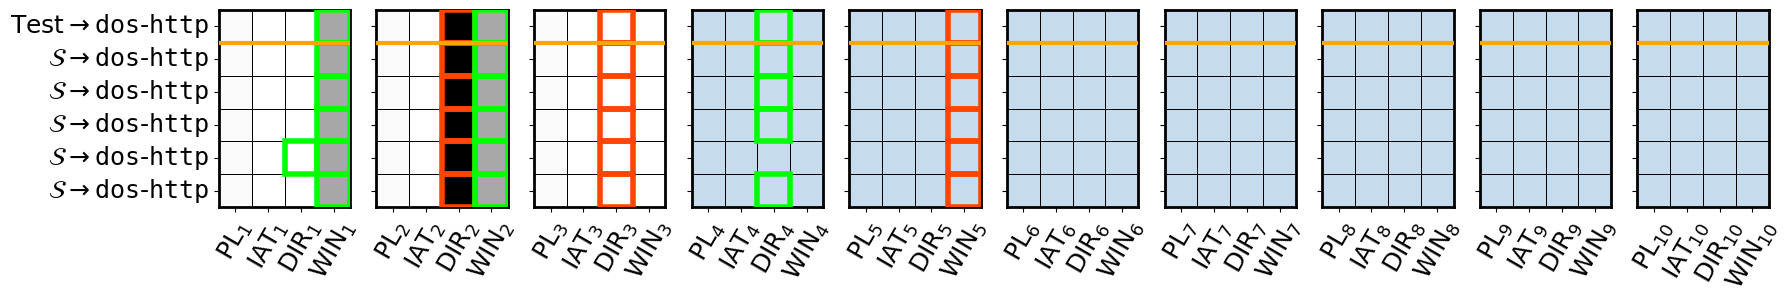

In [99]:
plot = np.concatenate(([inputs_tgt_corr_t[tgt]], top_k_inputs[0]))

plot = plot.flatten().reshape(6, 40)

plt.rcParams['font.size']=16
fig, axs = plt.subplots(1,10,figsize=(20, 7))

targets_considered_samples = [targeted_lbl] + top_k_lbls

mask_pl = np.zeros_like(plot)
for x in np.arange(0, 37, 4):
    mask_pl[:, x] = plot[:, x] ==0
    
mask_iat = np.zeros_like(plot)
for x in np.arange(0, 37, 4):
    mask_iat[:, x+1] = plot[:, x+1] ==0
    
mask_dir = np.zeros_like(plot)
for x in np.arange(0, 37, 4):
    mask_dir[:, x+2] = plot[:, x+2] ==0.5

mask_win = np.zeros_like(plot)
for x in np.arange(0, 37, 4):
    mask_win[:, x+3] = plot[:, x+3] ==0
mask = np.sum([mask_pl, mask_iat, mask_dir, mask_win], axis=0)

data = np.ones_like(plot)
print(targets_considered_samples)

for i, ax in enumerate(axs):
    g = sn.heatmap(data[:, 4*i:4*(i+1)], square=True, cmap='Blues_r', linewidths=0.5, linecolor='black', vmax=1.2, vmin=0.4, cbar=False, ax=ax)

for i, ax in enumerate(axs):
    g = sn.heatmap(plot[:, 4*i:4*(i+1)],
            cmap=sn.color_palette("Greys", as_cmap=True),
            linewidths=0.5, linecolor='k', vmin=0, vmax=1, cbar_kws = {"use_gridspec":False,"location":"top", "shrink":0.7},
            mask=mask[:,4*i:4*(i+1)],
            square=True, ax=ax, cbar=False)

n_classes = 6

for i, ax in enumerate(axs):
    ax.set_xticks(np.arange(4)+0.5, 
            [f'PL$_{{{i+1}}}$', f'IAT$_{{{i+1}}}$', f'DIR$_{{{i+1}}}$', f'WIN$_{{{i+1}}}$'], # + [f'IAT$_{x}$' for x in np.arange(10)] + [f'DIR$_{x}$' for x in np.arange(10)] + [f'WIN$_{x}$' for x in np.arange(10)],
            rotation=60, fontsize=18)
            
axs[0].set_yticks(np.arange(n_classes)+0.5, [
    r'$\mathrm{Test}\rightarrow$' + '-'.join(['$\mathtt{%s}$' % v for v in x.split('-')]) if d == 'TEST' else
    r'$\mathcal{S}\rightarrow$' + '-'.join(['$\mathtt{%s}$' % v for v in x.split('-')]) if d == 'SRC' else
    r'$\mathcal{T}\rightarrow$' + '-'.join(['$\mathtt{%s}$' % v for v in x.split('-')])
    for x, d in zip(targets_considered_samples, ['TEST'] + top_k_nb[0].tolist())], rotation=0, fontsize=18)

for ax in axs[1:]:
    ax.set_yticks(np.arange(n_classes)+0.5,['']*n_classes)

for ax in axs:
    ax.axhline(y=1, c='orange', lw=3, zorder=100)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')  # Border color
        spine.set_linewidth(2)    # Border width

for i, x in enumerate(shap_explanations):
    top4, worst4 = get_top_worst_index(x[0])
    for temp in top4:
        ax = axs[int(np.floor(temp/4))]
        
        ax.add_patch(plt.Rectangle((temp%4, i), 1, 1, fill=False, edgecolor='lime', lw=4, zorder=10))
        
    for temp in worst4:
        ax = axs[int(np.floor(temp/4))]
        ax.add_patch(plt.Rectangle((temp%4, i), 1, 1, fill=False, edgecolor='orangered', lw=4, zorder=9))

plt.savefig(f'samples_based_explanation_{tgt}_{discr}.pdf', dpi=300, bbox_inches='tight')
plt.show()